In [1]:
#%%
import math
import numpy as np
import inspect
import importlib

import scipy.interpolate

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 16

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.offline import plot
pio.renderers.default = "svg"

import sys
import os
parent_directory = os.path.dirname(os.getcwd())
sys.path.append(parent_directory)
#sys.path.append(os.path.dirname(parent_directory))
#sys.path.append(os.path.dirname(os.path.dirname(parent_directory)))

from IoT_node_models.Energy_model                        import *
from IoT_node_models.Energy_model.Wireless_communication import *
from IoT_node_models.Hardware_Modules                    import *
from IoT_node_models.Impact_model                        import *


path_to_save_svg = "Saved_Data"



Importing IoT Node models
Importing IoT Node Energy models
Importing IoT Node Energy models
Importing Wireless communication packages
Importing Wireless communication packages
Importing custom modules data
Importing custom modules data
Importing Impact models
Importing Impact models


In [2]:
show = 0

AA_series = 3
AA_footprint = 0.165
AA_cost      = 0.25 
Batt_footprint = AA_series*AA_footprint
Batt_cost      = AA_series*AA_cost

In [3]:
placementNnodes   = 100
decomNnodes       = 100
replacementNnodes = 10

In [4]:
transport_f =   transport_footprint(km_one_way = 10, 
                                    type ="Unit", 
                                    weight_g = 500,  
                                    footprint_p_tkm = 0.545,
                                    unit_factor = 1,
                                    footprint_p_km = 0.350)

node_footprint = Node_BoM(  casing            =[0.709,    0.3932, 1.3259], #709
                            connectivtiy      =[0.517,    0.2262, 0.5817],
                            eol               =[0.0812,   0.0388, 0.1201],
                            memory            =[0,        0,      0     ],
                            others            =[0.0938,   0.0546, 0.1394],
                            pcb               =[1.17,     0.9403, 1.5696], #1.17
                            power_supply      =[0.132,    0.0446, 0.1751],
                            processing        =[0.366,    0.3665, 0.4537],
                            sensing           =[0.0539,   0.0539, 0.5561],
                            ui                =[0.0306,   0.0017, 0.1155],
                            transport         =[transport_f*show,transport_f*show,transport_f*show],
                            battery           =[Batt_footprint  ,Batt_footprint,Batt_footprint],
                            placement         =[transport_f,transport_f,transport_f],
                            replacement       =[transport_f,transport_f,transport_f],
                            decom             =[transport_f,transport_f,transport_f], 
                            placementNnodes   = placementNnodes,
                            decomNnodes       = decomNnodes,
                            replacementNnodes = replacementNnodes)
    

In [5]:
transport_c =   transport_cost( worker = 1, 
                                salary_p_hour = 20, 
                                work_hour =0.3, 
                                km_p_h = 50,km_one_way = 10, 
                                type ="Unit", 
                                weight_g = 500, cost_p_tkm =  0.2/1e3,
                                unit_factor = 1,cost_p_km = 0.2)



node_Cost   = Node_BoM(     casing            =[10    ,    0 , 0], #ABS , IP rated
                            connectivtiy      =[5.3   ,    0 , 0], #SX1276 : 5.3
                            eol               =[0     ,    0 , 0],
                            memory            =[0     ,    0 , 0],
                            others            =[1.42  ,    0 , 0], #MLCC : 0.05*15 + XTAL32MHz: 0.5 + R: 0.002*15 + D : 0.07*2  
                            pcb               =[1.17  ,    0 , 0], #PCB 60cm2 : 1.75 
                            power_supply      =[0.228 ,    0 , 0], #XC6206 : 0.228 + Diode and Transistor?
                            processing        =[3.65  ,    0 , 0], #Apollo3: 3.65
                            sensing           =[6.94  ,    0 , 0], #BME680 : 6.94
                            ui                =[0.54  ,    0 , 0], #Push button : 0.17*2 + LED SMD : 0.2*1
                            transport         =[transport_c,0 , 0],
                            battery           =[Batt_cost  ,0 , 0],
                            placement         =[transport_c,0 , 0],
                            replacement       =[transport_c,0 , 0],
                            decom             =[transport_c,0 , 0],
                            placementNnodes   = placementNnodes,
                            decomNnodes       = decomNnodes,
                            replacementNnodes = replacementNnodes)

In [10]:
def PL_model(d):
    return path_loss_PLd0(d=d, PLd0=94.40,d0=1, n=2.03)

In [6]:
node_LDO = LDO(name = "Node LDO", v_out = 3.3, i_q = 1e-3, v_in = 3.3, module_list = module_List_3V3)
node_Batt= Battery(name = "Node Batt.", v = 3.3, capacity_mAh = 1800, i = 0, selfdischarge_p_year = 5)

node_lora = LoRa_Node(name= "IoT Node", module_list= module_List_3V3, PMU_composition =[node_LDO], Battery = node_Batt, MCU_module   = apollo_module_3V3, radio_module = radio_module_3V3)

node= LoRa_Node_profile("Node_profile", node_lora, MCU_active_state = apollo_state_active_3V3, RX_state=radio_state_RX_3V3,TX_state=radio_state_TX_3V3,
                    P_TX= PTX_PABOOST_configured, I_TX=I_PABoost_3V3 )
              
this_task_tx0 = node.create_task_tx(name="TX-0", Ptx = 17,SF=7 ,Coding=1,Header=True,DE = 1,BW = 125e3, Payload = 50, TX_rate=24*1)
this_task_rx0 = node.create_task_rx(name="RX-0", RX_rate=2, RX_duration=0.250 )

this_task_tx1 = node.create_task_tx(name="TX-1", Ptx = 17,SF=12 ,Coding=1,Header=True,DE = 1,BW = 125e3, Payload = 50, TX_rate=24*1)
this_task_rx1 = node.create_task_rx(name="RX-1", RX_rate=10, RX_duration=0.250 )


#node.change_task_rate(this_task_rx,0)
#node.change_task_rate(this_task_tx,24*4)
#node.add_task(task_TPHG_3V3,24*12)

In [7]:
figsize = (6,3.8) #figsize = (5,4)

3.6485000000000003


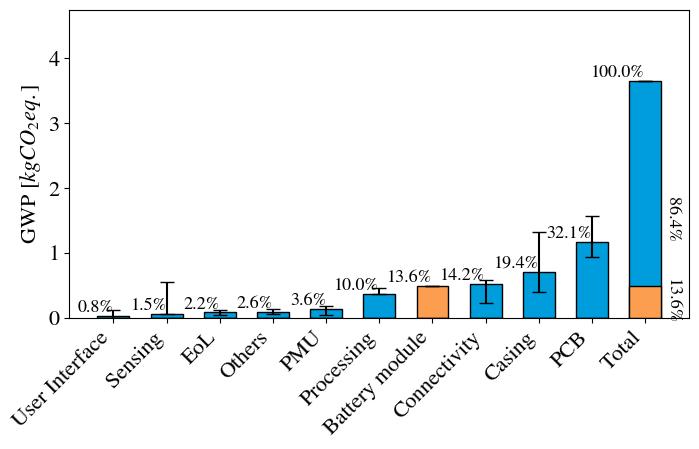

In [8]:
node_footprint.plot_footprint(filename = os.path.join(path_to_save_svg , "Node_Footprint_breakdown") ,figsize =(8,4),separatePlot=False)

-------------------------------------------------
            Tasks summary                        
-------------------------------------------------
Task name            : Sleep          TX-0           RX-0           TX-1           RX-1           
Times/day    [1/d]   : 1              24             2              24             10             
Tot. durat.  [s]     : 86320.6750     62.4468        1.1000         10.2781        5.5000         
Tot. en./d   [mJ]    : 10290.1409     16214.0662     19.8713        617.2325       99.3564        
Node en./d   [mJ]    : 27240.6672      
Average pow. [mW]    : 0.3153          
-------------------------------------------------
-----------------------------------------------------------------
                        Module summary                           
-----------------------------------------------------------------
Module       State        Active [s]   Energy [mJ]  Av. Cur.[uA]  
Apollo3                   18.0000      809.8600     2.8404 

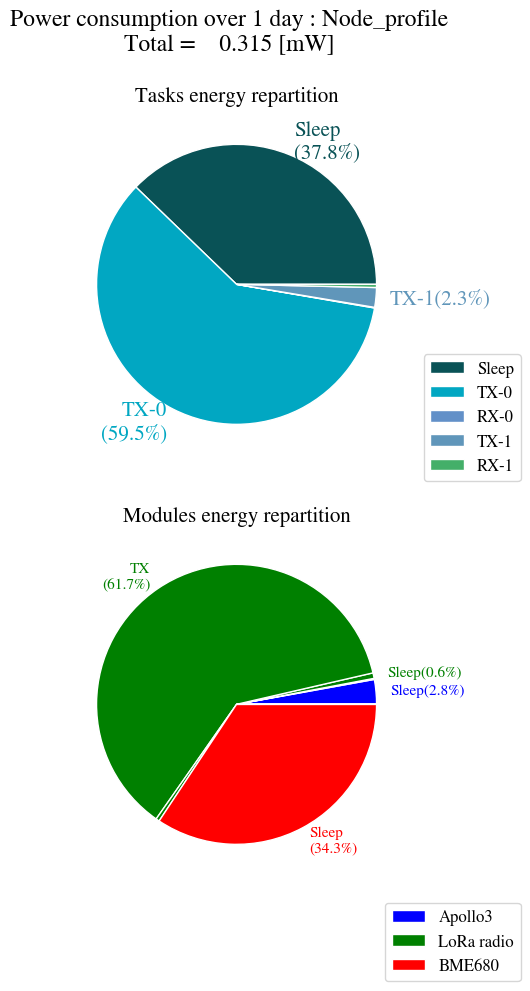

In [13]:
this_task_tx0.set_Path_loss_model(PL_model)
this_task_tx1.set_Path_loss_model(PL_model)

this_task_tx0.set_distance( d= 1500)
this_task_tx1.set_distance( d= 200)

node.compute()
node.print_Tasks()
node.print_Modules()
node.plot_Power()

In [19]:
node.set_distance(d= 1500)
[res1,res2,lifetime,residue] =deployment_battery_replacement(
                                    Replacement_type = "Complete",
                                    Footprint=node_footprint,
                                    Node=node,
                                    Nyears= 20)
                        
print([res1,res2,lifetime,residue])

[8.496525000000002, 8.303387497384257, 1.5762366298937063, 0.6131456618410951]


In [15]:
def F_trans(km):
    return transport_footprint(km_one_way = km, type ="Unit", 
                            weight_g = 500,  footprint_p_tkm = 0.545,
                            unit_factor = 1,footprint_p_km = 0.350,km_fixed = 5)

def C_trans(km):
    return transport_cost(  worker = 1, salary_p_hour = 5, work_hour =10/60, km_p_h = 50,km_one_way = km, 
                            type ="Unit", 
                            weight_g = 500, cost_p_tkm =  0.2/1e3,
                            unit_factor = 1,cost_p_km = 0.2)